In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
from scipy import signal
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
#Generate Network
this_seed=8637#np.random.randint(10000)
Network=edamame.core.generate_network(300,this_seed=this_seed)

2021-04-27 13:36:04,644:INFO:Detecting junctions
2021-04-27 13:36:06,039:INFO:Finished detecting junctions
2021-04-27 13:36:06,085:INFO:The returned network has 5114 junctions.


In [4]:
connectivity=connectivity__(wires_dict=Network)

Initialise Input Electrodes + Target Electrodes

In [20]:
# FUNCTIONS
def pattern(pattern_type):
    if pattern_type == 1:
        training_list=[0,2,4,9,10,11] #drains, then sources
    elif pattern_type == 2:
        training_list=[4,7,8,9,10,11] #drains, then sources
    elif pattern_type == 3:
        training_list=[0,4,8,9,10,11] #drains, then sources
    return training_list

def boolPattern(pattern_type,amp):
    if pattern_type == 1:
        boolTargets=np.array([amp,0,amp,0,amp,0,0,0,0]).astype(bool)
    elif pattern_type == 2:
        boolTargets=np.array([0,0,0,0,amp,0,0,amp,amp]).astype(bool)
    elif pattern_type == 3:
        boolTargets=np.array([amp,0,0,0,amp,0,0,0,amp]).astype(bool)
    return boolTargets

def runTraining(connectivity,training_stimulus,numTraining,T=1,electrodes=[]):
    training_state=[None]*numTraining #network state for training   
    training_sims=[None]*numTraining
    for i in range(numTraining):
        if i > 0:
            training_sims[i]=runSim(connectivity, start_state=training_state[i-1], stimulus=training_stimulus,T=T, contactMode='preSet', electrodes=electrodes, findFirst=False,collapse=True,disable_tqdm=True)
        else:
            training_sims[i]=runSim(connectivity, stimulus=training_stimulus, contactMode='preSet',T=T, electrodes=electrodes, findFirst=False,collapse=True,disable_tqdm=True)

    #save state of training sim to start from there in next training sim
    training_state[i]=getJunctionState(training_sims[i])
    return training_sims[i],training_state[i]

def runTesting(connectivity,training_state,testing_stimulus,onAmp=1,dt=0.001,f=0.5,T=1,electrodes=[]):
    testing_sims=runSim(connectivity, start_state=training_state, stimulus=testing_stimulus, contactMode='preSet', electrodes=electrodes,T=T, onAmp=onAmp, dt=dt, f=f, findFirst=False,collapse=True,disable_tqdm=True)
    testing_state=getJunctionState(testing_sims)
    return testing_sims,testing_state


def drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets):

    #Compare training current output of target drains (open) with testing current output of target drains (open)
    drain_training={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}
    drain_testing={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}
    
    for i in range((num_drain_training)):
        #Target Drains: 
        temp=b_testing[drainAndSourceTargets]
        drain_training['Target'][i]=wireCurrentTimeSeries(training_sims, temp[i])
        drain_testing['Target'][i]=wireCurrentTimeSeries(testing_sims, temp[i])
    #Compare training current output of non-target drains (closed) with testing current output of non-target drains (open)
    #Non-Target Drains: 
    for i in range((num_drain_testing-num_drain_training)):
        temp2=b_testing[~drainAndSourceTargets][:-3]
        drain_training['Non-Target'][i]=wireCurrentTimeSeries(training_sims, temp2[i])
        drain_testing['Non-Target'][i]=wireCurrentTimeSeries(testing_sims, temp2[i])
        
    return drain_training, drain_testing

def cross_correlate(drain_testing):
    sclistTarget=[None]*len(drain_testing['Target'])
    sclistNonTarget=[None]*len(drain_testing['Non-Target'])
    # DOT PRODUCT CROSS CORRLATION
    for i in range(len(drain_testing['Target'])): #for number of training sessions
        a=drain_training['Target'][i][:500].reshape(-1)
        b=drain_testing['Target'][i].reshape(-1)
        #take the first 500 seconds of training signal and compare to testing signal
        sclistTarget[i]=np.dot(a,b) 

    for i in range(len(drain_testing['Non-Target'])): #for number of training sessions
        a=drain_training['Non-Target'][i][:500].reshape(-1)
        b=drain_testing['Non-Target'][i].reshape(-1)
        #take the first 500 seconds of training signal and compare to testing signal
        sclistNonTarget[i]=np.dot(a,b)
    
    return sclistTarget,sclistNonTarget


def calc_grid(boolTargets):
    grid = np.zeros(9)

    gridTarget=[i for i, x in enumerate(boolTargets) if x] #find target electrodes
    gridNonTarget=[i for i, x in enumerate(boolTargets) if ~x] #find non-target electrodes

    grid[gridTarget] = sclistTarget #find crosscorrelation values of target electrodes
    grid[gridNonTarget] = sclistNonTarget #find crosscorrelation values of non-target electrodes

    grid=(grid.reshape(3,3))

    return grid
def calc_normal_grid(boolTargets,maxOrigGrid,minOrigGrid,meanOrigGrid,grid):
    normalizedGrid=[]
    for i in range(len(grid)):
        normalizedGrid.append((grid[i]-meanOrigGrid)/(maxOrigGrid-minOrigGrid))
    normalizedGrid=np.array(normalizedGrid).reshape(-1)
    return normalizedGrid

def plot_grid(grid,boolTargets):
    #Plot cross-correlation grid: 
    fig1 = plt.figure(figsize=(11,11))
    ax1=fig1.add_subplot(1, 2, 1)
    ax1.title.set_text('Output Dot Products')
    plt.imshow(grid,interpolation='none',cmap='plasma')#norm=clrs.LogNorm())
    plt.colorbar(shrink=0.5)

    ax2=fig1.add_subplot(1, 2, 2)
    ax2.title.set_text('Target')
    plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')
    plt.colorbar(shrink=0.5)

    #Remove Tick Labels
    fig1.axes[0].get_xaxis().set_ticklabels([])
    fig1.axes[0].get_yaxis().set_ticklabels([])
    fig1.axes[2].get_xaxis().set_ticklabels([])
    fig1.axes[2].get_yaxis().set_ticklabels([])
    

def changeVoltage(drain_training,boolTargets,normalizedGrid,threshold,onAmp=1,dt=0.001,f=0.5,T=1):
    
    for i in range(len(normalizedGrid[boolTargets])):
        if normalizedGrid[boolTargets][i]<threshold: # if the output voltages for the targets are less than the threshold
#             set_trace()
            training_stimulus[-3:][i].signal=training_stimulus[-3:][i].signal*1.05#=(stimulus__(biasType='DC',onAmp=onAmp[i]*1.05,TimeVector=np.arange(0,T,dt),f=f)) #increase voltage by 5%
            training_stimulus[-3:][i].onAmp=training_stimulus[-3:][i].onAmp*1.05    
            print('Input Electrode ' + str(i+1) + ' Increased by 5%')
    
    count=0
    whichElectrodes=np.argwhere(normalizedGrid[~boolTargets]>threshold)
    if len(whichElectrodes)!=0:
        for i in whichElectrodes:
    #         if normalizedGrid[~boolTargets][i]>threshold: #if the output voltages for the targets are more than the threshold
            testing_stimulus[:-3][i]=(stimulus__(biasType='DC',onAmp=0.1,TimeVector=np.arange(0,T,dt),f=f)) #decrease voltage by 5%
            print('Output Electrode ' + str(count) + ' Changed to 0.1')
    return training_stimulus


In [6]:
#Initialise Training + Testing:
numSessions=2
numTraining = 1 #how many training simulations to run per session
numTesting = 1

#Testing and Training patterns: 
# 9 drains, 3 sources
b_testing=np.array([194, 230, 79, 34, 127, 169, 133, 264, 91, 272,117, 148])#edamame.core.getBoundaryPairing(connectivity,9)
b_training=b_testing[:]

pattern_type=1 # CHANGE PATTERN TYPE
num_source_training=3
num_drain_training=3

training_list = pattern(pattern_type)

# Open Electrodes for testing
testing_list=[0,1,2,3,4,5,6,7,8,9,10,11]#Drains then sources

num_source_testing=num_source_training
num_drain_testing=len(testing_list)-num_source_testing

b_testing=b_testing[testing_list]
b_training=b_training[training_list]

In [7]:
num_drain_training

3

In [8]:
#Initialise stimulus:
onAmp_training = 1 #amplitude for training
onAmp_testing=0.2 #amplitude for testing
signal_time = 0.5
rest_time = 0.5
rest_between_training=30
run_time=signal_time+rest_time
dt = 0.001
f= 0.5

training_stimulus = []
testing_stimulus = []
resting_stimulus=[]
training_sims=[None]*numTraining
testing_sims=[None]*numTesting
testing_state=[None]*numTesting
resting_sims=[None]*(numSessions-1) #rest between sessions

#TRAINING STIMULUS
# ONLY DRAINS WITH CORRESPONDING STIMULUS SOURCE ARE ACTIVE
#Drains: 
for i in range(num_drain_training):
    #DRAIN WITHOUT REST
    training_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,run_time,dt))))
#     resting_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))

#Sources
for i in range(num_source_training):
    #SOURCE WITHOUT REST
    training_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,run_time,dt),f=f)))
    
    #ADD REST AT THE END
#     training_stimulus[(num_drain_training)+i].signal=np.concatenate([np.array(stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f).signal), np.array([0.005]*int(rest_time/dt))]) 
    
#     REST BETWEEN SESSIONS
#     resting_stimulus.append((stimulus__(biasType='DC',onAmp=0.0001,TimeVector=np.arange(0,rest_between_training,dt),f=f)))


#CONVERT TO BOOLEAN FOR TARGET PATTERN:
boolTargets=boolPattern(pattern_type,onAmp_training)
drainAndSourceTargets=np.hstack((boolTargets,np.zeros(num_source_training).astype(bool)))

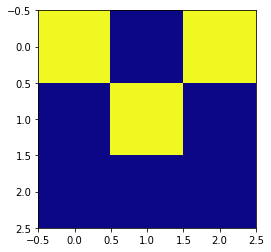

In [9]:
#Show target
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')

## TRAINING

In [10]:
#Run Training
training_sims,training_state=runTraining(connectivity,training_stimulus,numTraining,T=run_time,electrodes=b_training)

In [11]:
nontargetElectrodes=list(set(testing_list) - set(training_list))
targetElectrodes=list(set(testing_list) - (set(testing_list) - set(training_list)))
inputElectrodes=targetElectrodes[-num_source_training:]
targetElectrodes=targetElectrodes[:-num_source_training]#remove source electrodes

In [12]:
# #Visualise Training Electrode Positions
# draw_graph(training_sims, time = 0.99, figsize=(10,10),colorbar=True)
# G = nx.from_numpy_array(training_sims.connectivity.adj_matrix)
# pos=nx.kamada_kawai_layout(G)
# #highlight input, target and output nodes:
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[targetElectrodes]),node_color='#840000',edgecolors=None)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[nontargetElectrodes]),node_color='k',edgecolors=None)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[inputElectrodes]),node_color='g',edgecolors=None)

## TESTING

In [13]:
#TESTING STIMULUS:
testing_stimulus=[]
#Drains: 
for i in range(num_drain_testing):
    testing_stimulus.append((stimulus__(biasType='DC',onAmp=0,TimeVector=np.arange(0,signal_time,dt))))
#Sources
for i in range(num_source_testing):
    testing_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_testing,TimeVector=np.arange(0,signal_time,dt),f=f)))

In [14]:
#Run Test
resting_state=[]

#Run test by feeding in the network states after training epochs  
testing_sims,testing_state=runTesting(connectivity,training_state,testing_stimulus,onAmp=onAmp_testing,dt=dt,f=f,T=signal_time,electrodes=b_testing)

#     print("Rest " + str(i+1))
    #After we test, we want to let the network rest for 30 seconds before running more training epochs later
#     resting_sims[i]=(runSim(connectivity, start_state=testing_state[-1], stimulus=resting_stimulus, contactMode='preSet', electrodes=b_training,T=rest_between_training, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True))
#     resting_state.append(getJunctionState(resting_sims[i]))

In [15]:
# #Visualise Training Electrode Positions
# draw_graph(testing_sims, time = 0.49, figsize=(10,10),colorbar=True)
# G = nx.from_numpy_array(training_sims.connectivity.adj_matrix)
# pos=nx.kamada_kawai_layout(G)
# #highlight input, target and output nodes:
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[targetElectrodes]),node_color='#840000',edgecolors=None)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[nontargetElectrodes]),node_color='r',edgecolors=None)
# nx.draw_networkx_nodes(G,pos=pos,nodelist=list(b_testing[inputElectrodes]),node_color='g',edgecolors=None)

In [16]:
#Assign Data to Target and Non-Target
drain_training,drain_testing=drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets)

## Cross Correlation

In [17]:
#CROSS CORRELATION:

sclistTarget,sclistNonTarget=cross_correlate(drain_testing)
    
#Adrian Cross Correlation    
# I_ave=[None]*numSessions
# I_tar=[None]*numSessions
# sclist[0],I_tar[0],I_ave[0]=cross_correlation_adrian(testing_sims[-1],boolTargets)

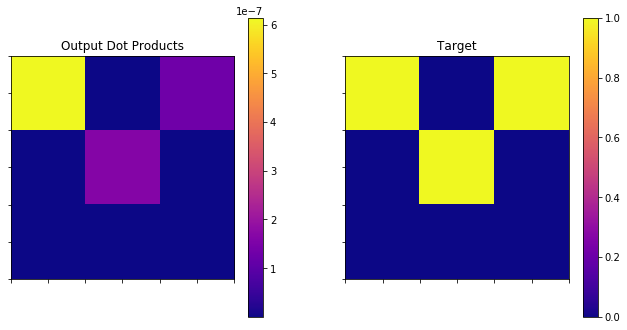

In [21]:
grid=calc_grid(boolTargets)

maxOrigGrid=(np.max(grid))
minOrigGrid=(np.min(grid))
meanOrigGrid=(np.mean(grid))
normalized_grid=calc_normal_grid(boolTargets,maxOrigGrid,minOrigGrid,meanOrigGrid,grid)
    
plot_grid(grid,boolTargets)

In [22]:
normalized_grid

array([ 0.83531579, -0.16448172,  0.04959618, -0.16461883,  0.1023385 ,
       -0.16468371, -0.16468421, -0.16412325, -0.16465875])

In [23]:
#NORMALIZE GRID
normalized_grid[boolTargets]

array([0.83531579, 0.04959618, 0.1023385 ])

After training and testing once, we want to change the input voltages based on the output:

If the target is [1,0,0;0,1,0;0,0,1] but the output after training and testing is [1,0,0;0,1,0;0,1,1] for example, we want to reduce the  input voltages responsible for row 2 and 3


In [32]:
## REPEAT - BUT INCREASE VOLTAGE OF STIMULUS IN ROW THAT WAS INCORRECT
threshold=5#set threshold to 0.5
training_stimulus=changeVoltage(drain_training,boolTargets,normalized_grid,threshold,onAmp=[(onAmp_training)]*3)

Input Electrode 1 Increased by 5%
Input Electrode 2 Increased by 5%
Input Electrode 3 Increased by 5%


In [33]:
newOnAmp=[]
for i in range(len(training_stimulus)):
    newOnAmp.append(training_stimulus[i].onAmp)

In [34]:
newOnAmp

[1, 1, 1, 1.05, 1.2762815625000004, 1.2155062500000002]

## REPEAT TRAINING AND TESTING

In [35]:
from IPython.display import clear_output

1%
Target Outputs [1.5581714  0.76880861 1.80914563]
NonTarget Outputs [-0.164255   -0.16457459 -0.16468354 -0.16468419 -0.16463524 -0.16417316]
Input Electrode 1 Increased by 5%
Input Electrode 2 Increased by 5%
Input Electrode 3 Increased by 5%
Training Voltages [1, 1, 1, 1.05, 1.2762815625000004, 1.2155062500000002]
2%
Target Outputs [1.78201211 1.01085832 2.539387  ]
NonTarget Outputs [-0.16419472 -0.16456706 -0.16468349 -0.16468419 -0.16455596 -0.16412732]
Input Electrode 1 Increased by 5%
Input Electrode 2 Increased by 5%
Input Electrode 3 Increased by 5%
Training Voltages [1, 1, 1, 1.1025, 1.3400956406250004, 1.2762815625000004]
3%
Target Outputs [1.87840375 1.1907722  3.21472197]
NonTarget Outputs [-0.16411823 -0.16456459 -0.16468167 -0.16468419 -0.16344399 -0.16384245]
Input Electrode 1 Increased by 5%
Input Electrode 2 Increased by 5%
Input Electrode 3 Increased by 5%
Training Voltages [1, 1, 1, 1.1576250000000001, 1.4071004226562505, 1.3400956406250004]
4%
Target Outputs [2.

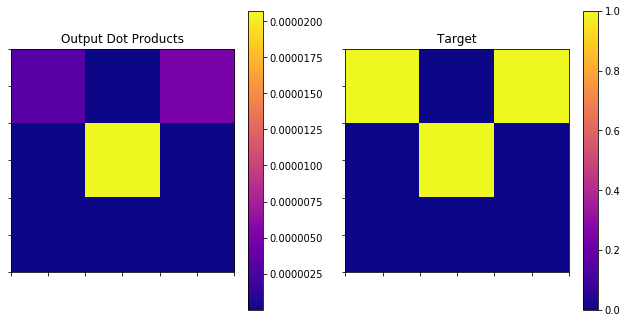

In [36]:
count=0
onAmps=[]
numIterations=100
normalized_grid2=[]
grid2=[]
for iters in range(100):
    print(str(iters+1)+'%')
    #Run training
    training_sims,training_state=runTraining(connectivity,training_stimulus,numTraining,electrodes=b_training)
    
    #Run testing
    testing_sims,testing_state=runTesting(connectivity,training_state,testing_stimulus,onAmp=onAmp_testing,dt=dt,f=f,T=signal_time,electrodes=b_testing)
    
    #Assign drains
    drain_training,drain_testing=drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets)
    
    #Run Cross correlation
    sclistTarget,sclistNonTarget=cross_correlate(drain_testing)
    grid2.append(calc_grid(boolTargets))
    normalized_grid2.append(calc_normal_grid(boolTargets,maxOrigGrid,minOrigGrid,meanOrigGrid,grid2[iters]))

    print('Target Outputs ' + str(normalized_grid2[iters][boolTargets]))
    print('NonTarget Outputs ' + str(normalized_grid2[iters][~boolTargets]))
    #change voltage
    newOnAmp=[]
    for i in range(len(training_stimulus)):
        newOnAmp.append(training_stimulus[i].onAmp)
    training_stimulus=changeVoltage(drain_training,boolTargets,normalized_grid2[iters],threshold,T=run_time,onAmp=newOnAmp)
    onAmps.append(newOnAmp)
    print('Training Voltages ' + str(onAmps[iters]))

    if np.array(normalized_grid2[iters]).reshape(-1)[boolTargets][0]>threshold and normalized_grid2[iters][boolTargets][1] >threshold and normalized_grid2[iters][boolTargets][2] >threshold:
        break;
        
    if np.array(grid2[iters]).reshape(-1)[boolTargets][0]>5e-4 and np.array(grid2[iters]).reshape(-1)[boolTargets][0]>5e-4  and np.array(grid2[iters]).reshape(-1)[boolTargets][0]>5e-4 :
        break;
    
    
plot_grid(grid2[-1],boolTargets)   
        

In [39]:
grid2[iters]

array([[3.19807483e-06, 1.33761988e-08, 4.91833434e-06],
       [3.14269325e-08, 2.07151210e-05, 5.34460226e-10],
       [2.02732675e-11, 7.31220823e-08, 1.07586572e-08]])

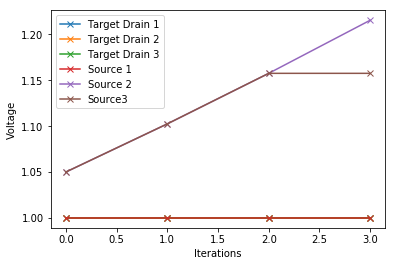

In [31]:
a=plt.plot(onAmps,'-x')
plt.xlabel('Iterations')
plt.ylabel('Voltage')
plt.legend(a,['Target Drain 1','Target Drain 2','Target Drain 3','Source 1', 'Source 2', 'Source3'])

In [40]:
np.array(grid2[0]).reshape(-1)[~boolTargets]

array([1.48541249e-10, 4.65964105e-11, 3.50268254e-13, 3.75505037e-14,
       4.10824225e-10, 2.56797149e-11])

In [39]:
np.array(grid2[-1]).reshape(-1)[~boolTargets]

array([4.49645618e-08, 1.01349037e-07, 4.14408659e-08, 1.37683660e-13,
       1.97665248e-07, 8.26280082e-08])

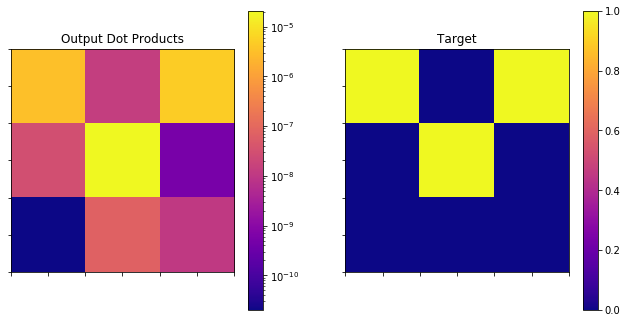

In [43]:
plot_grid(grid2[-1],boolTargets)   


In [42]:
normalized_grid2[iters]

array([ 0.15854191, -0.23782141, -0.24337975, -0.24303388,  0.47803823,
       -0.24337916, -0.24337982, -0.18220631,  0.75662018])

In [ ]:
# OLD METHOD

In [42]:
# #Run Training
# training_state=[None]*numTraining #network state for training
# testing_state=[None]*numTesting #network state for testing
# for i in range(numTraining):
#     print("Training " + str(i+1))
#     training_sims[i],training_state[i]=runTraining(connectivity,training_state,training_sims,onAmp=newOnAmp,dt=dt,f=f,T=run_time,electrodes=b_training)

In [43]:
# #Run Test
# resting_state=[]
# for i in range(numTesting):
#     print("Testing " + str(i+1))
#     #Run test by feeding in the network states after training epochs  
#     testing_sims[i],testing_state[i]=runTesting(connectivity,training_state,testing_stimulus,onAmp=onAmp_testing,dt=dt,f=f,T=signal_time,electrodes=b_testing)

In [44]:
# #CROSS CORRELATION:
# sclistTarget,sclistNonTarget=cross_correlate(drain_testing)

In [45]:
# normalized_grid,grid=plot_grid(boolTargets)

In [46]:
# normalizedGrid[boolTargets]
# normalizedGrid=np.array(normalizedGrid).reshape(-1)